<a href="https://colab.research.google.com/github/KaiWoessner/NFLDataAnalysis/blob/main/NFLGameDrives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the library for NFL Data
!pip install nfl_data_py
import nfl_data_py as nfl

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import axes
import matplotlib.patches as patches
import numpy as np
from PIL import Image

from google.colab import drive

drive.mount('/content/drive', force_remount=False)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.6 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=a43e24b292af1035e0e554cd4701befce098bcffa5b66ea02b3f03f5925f9574
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py
Mounted at /content/drive


In [ ]:
gm = nfl.import_pbp_data([2023])
pd.set_option('display.max_columns', None)
gm = gm[gm["game_id"] == "2023_03_LAC_MIN"]

gm.head(30)

2023 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [ ]:
lac_min = gm[["posteam","play_type", "drive", "qtr", "time", "yardline_100", "ydsnet", "drive_end_transition"]]

# lac_min = lac_min[(lac_min["play_type"] == "pass") | (lac_min["play_type"] == "run") | (lac_min["play_type"] == "no_play")]
lac_min = lac_min[lac_min['play_type'] != "kickoff"]
lac_min = lac_min[lac_min['play_type'] != "extra_point"]

lac_min = lac_min.sort_values(by = ["qtr","time"], ascending = [True, False]).reset_index(drop = True)

drive_start = lac_min.groupby('drive').first().reset_index()
drive_end = lac_min.groupby('drive').last().reset_index()

drive = pd.merge(drive_start, drive_end, on=['drive'])

drive = drive.rename(columns={'qtr_x': 'qtr',
  'posteam_x': 'posteam',
  'yardline_100_y': 'yardline_end',
  'yardline_100_x': 'yardline_start',
  'drive_end_transition_x': 'drive_result'})

drive_final = drive[["drive", "posteam", "qtr", "yardline_start", "yardline_end", "drive_result"]]

drive_final.loc[drive_final['drive_result'] == "TOUCHDOWN", ['yardline_end']] = 0

qtr_drive = drive_final.groupby('qtr').last().reset_index()

print(qtr_drive)
#drive_final.head(24)

   qtr  drive posteam  yardline_start  yardline_end drive_result
0  1.0    4.0     MIN            75.0          53.0         PUNT
1  2.0   10.0     MIN            75.0          51.0     END_HALF
2  3.0   17.0     MIN            83.0           0.0    TOUCHDOWN
3  4.0   22.0     LAC            80.0          80.0     END_GAME


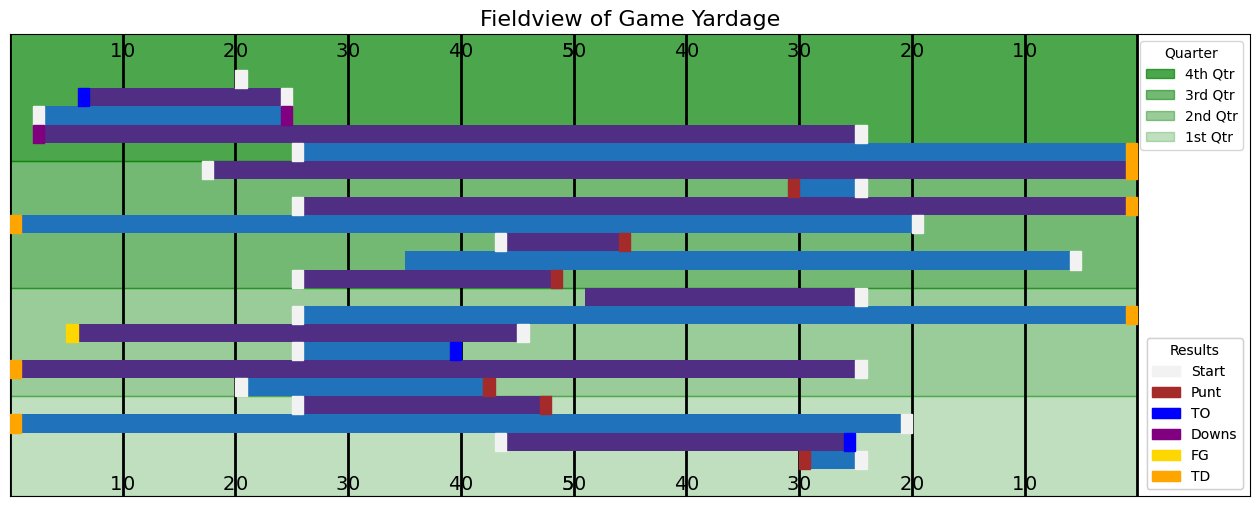

In [49]:
teamcolor = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

tm_colors = [teamcolor.get(team) for team in drive_final["posteam"]]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 6))

field_width = (len(drive_final["drive"])) * 4 - 2
field_length = 100

# Set the background color to green
ax.add_patch(patches.Rectangle((0, -8), 100, qtr_drive["drive"][0]*4+6, color="green", alpha=0.25, zorder=2))
ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][0]*4-2), 100, (qtr_drive["drive"][1]*4 - qtr_drive["drive"][0]*4), color="green", alpha=0.4, zorder=2))
ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][1]*4-2), 100, (qtr_drive["drive"][2]*4 - qtr_drive["drive"][1]*4), color="green", alpha=0.55, zorder=2))
ax.add_patch(patches.Rectangle((0, qtr_drive["drive"][2]*4-2), 100, qtr_drive["drive"][3]*4+8, color="green", alpha=0.7, zorder=2))

# Plot the field
#plt.plot([0, 0, field_length, field_length], [0, field_width+8, field_width+8, 0], color='white', lw=2)
plt.xlim(0, field_length + 10)
plt.ylim(-8, field_width + 8)

# Creates Bars
for i in range(len(drive_final["drive"])):
  if drive_final["qtr"][i] % 2 != 0:

    if (drive_final["posteam"][i] == "LAC"):
      plt.barh(4*i, drive_final["yardline_end"][i]  -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == "MIN"):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

  if drive_final["qtr"][i] % 2 == 0:

    if (drive_final["posteam"][i] == "LAC"):
      plt.barh(4*i, drive_final["yardline_start"][i] -  drive_final["yardline_end"][i], left=(100-drive_final["yardline_start"][i]), height=4, color=tm_colors[i], zorder = 10)

    if (drive_final["posteam"][i] == "MIN"):
      plt.barh(4*i, drive_final["yardline_end"][i] -  drive_final["yardline_start"][i], left=drive_final["yardline_start"][i], height=4, color=tm_colors[i], zorder = 10)


# Start Lines
for i in range(len(drive_final["drive"])):
    bottom = 4 * i - 2

    if drive_final["qtr"][i] % 2 != 0:
        if (drive_final["posteam"][i] == "LAC"):
          plt.gca().add_patch(patches.Rectangle((drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

        if (drive_final["posteam"][i] == "MIN"):
          plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

    if drive_final["qtr"][i] % 2 == 0:

        if (drive_final["posteam"][i] == "LAC"):
          plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

        if (drive_final["posteam"][i] == "MIN"):
          plt.gca().add_patch(patches.Rectangle((drive_final["yardline_start"][i], bottom), 1, 4, color="0.95", zorder = 20))

# Scoring
for i in range(len(drive_final["drive"])):
    bottom = 4 * i - 2

    if (drive_final["drive_result"][i] == "TOUCHDOWN"):
      if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((0, bottom), 1, 4, color="orange", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((99, bottom), 1, 4, color="orange", zorder = 25))

      if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((99, bottom), 1, 4, color="orange", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((0, bottom), 1, 4, color="orange", zorder = 25))

    if (drive_final["drive_result"][i] == "FIELD_GOAL"):
        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="gold", zorder = 25))

    if (drive_final["drive_result"][i] == "PUNT"):

        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="brown", zorder = 25))

    if (drive_final["drive_result"][i] in ["INTERCEPTION", "FUMBLE"]):

        if drive_final["qtr"][i] % 2 != 0:
          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((100-drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="b", zorder = 25))

    if (drive_final["drive_result"][i] == "DOWNS"):

        if drive_final["qtr"][i] % 2 != 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((100 - drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

        if drive_final["qtr"][i] % 2 == 0:

          if (drive_final["posteam"][i] == "LAC"):
            plt.gca().add_patch(patches.Rectangle((100 - drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

          if (drive_final["posteam"][i] == "MIN"):
            plt.gca().add_patch(patches.Rectangle((drive_final["yardline_end"][i], bottom), 1, 4, color="purple", zorder = 25))

# Yard lines
for i in range(11):
  line =10 * i
  plt.axvline(line, color='k', linewidth = 2, zorder = 9)

# Yard lines Numbers
count = 1
for i in range(10, 51, 10):
  plt.text(i, -6.5, str(count), fontsize=14, color='k', ha='right')
  plt.text(100-i, -6.5, str(count), fontsize=14, color='k', ha='right')

  plt.text(i, 89, str(count), fontsize=14, color='k', ha='right')
  plt.text(100-i, 89, str(count), fontsize=14, color='k', ha='right')

  count += 1


for i in range(10, 100, 10):
  plt.text(i, -6.5, str(0), fontsize=14, color='k', ha='left')
  plt.text(i, 89, str(0), fontsize=14, color='k', ha='left')


# Title
ax.set_title('Fieldview of Game Yardage', fontsize=16)

# Legend
fourth = mpatches.Patch(color='green', alpha = 0.7, label='4th Qtr')
third = mpatches.Patch(color='green', alpha = 0.55, label='3rd Qtr')
second = mpatches.Patch(color='green', alpha = 0.4, label='2nd Qtr')
first = mpatches.Patch(color='green', alpha = 0.25, label='1st Qtr')
quarter = ax.legend(handles=[fourth, third, second, first], loc='upper right')
quarter.set_title('Quarter')
ax.add_artist(quarter)

drive_start = mpatches.Patch(color='0.95', label='Start')
punt = mpatches.Patch(color='brown', label='Punt')
to = mpatches.Patch(color='b', label='TO')
to_on_downs = mpatches.Patch(color='purple', label='Downs')
field_goal = mpatches.Patch(color='gold', label='FG')
touchdown = mpatches.Patch(color='orange', label='TD')

markers = ax.legend(handles=[drive_start, punt, to, to_on_downs, field_goal, touchdown], loc='lower right')
markers.set_title('Results')
ax.add_artist(markers)

plt.xticks([])
plt.yticks([])
# Display the field
plt.show()